In [2]:
import pandas as pd
import numpy as np
import itertools

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import r_regression, SelectPercentile
from scipy.stats import loguniform, beta, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score

import warnings

warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data/waterQuality.csv')

# Introduction
The following problem is a binary classification problem, based on the Water Quality dataset. It contains columns with chemical components of water and their values, and the target column, 'is_safe' which contains 0 if the water is not safe to drink and 1 if it is.

The aim of this notebook is therefore to identify a model that can accurately predict whether a sample of water is safe or not based on chemical component levels.

# Exploratory data analysis

The dataset has about 8000 rows and 20 features.
I begin by conducting some exploratory data analysis, mainly checking for missing values or NaNs, and get an idea of how the data is distributed. The dataset is already pretty clean, except for a few values.

In [4]:
data

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,0.05,7.78,0.00,1.95,0.040,0.10,0.03,0.03,1.37,0.00,...,0.197,14.29,1.00,0.005,3.57,2.13,0.09,0.06,0.03,1
7995,0.05,24.22,0.02,0.59,0.010,0.45,0.02,0.02,1.48,0.00,...,0.031,10.27,1.00,0.001,1.48,1.11,0.09,0.10,0.08,1
7996,0.09,6.85,0.00,0.61,0.030,0.05,0.05,0.02,0.91,0.00,...,0.182,15.92,1.00,0.000,1.35,4.84,0.00,0.04,0.05,1
7997,0.01,10,0.01,2.00,0.000,2.00,0.00,0.09,0.00,0.00,...,0.000,0.00,0.00,0.000,0.00,0.00,0.00,0.00,0.00,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

Notice that there are a few values set to #NUM! in columns 'ammonia' and 'is_safe'. Since they're in the same lines, and it's only 3 of them, I simply drop the corresponding rows. 

In [6]:
data[data['is_safe'] == '#NUM!']

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
7551,0.03,#NUM!,0.08,0.79,0.07,0.08,0.05,0.58,0.34,0.00,...,0.183,4.37,1.43,0.007,0.62,2.54,0.07,0.05,0.05,#NUM!
7568,0.06,#NUM!,0.07,1.72,0.08,0.32,0.01,1.11,0.61,0.00,...,0.178,12.10,2.03,0.008,1.37,2.05,0.06,0.10,0.07,#NUM!
7890,0.01,#NUM!,0.08,0.49,0.00,0.07,0.09,0.06,0.72,0.57,...,0.088,9.57,1.45,0.009,7.67,7.70,0.03,0.05,0.02,#NUM!


In [7]:
data[data['ammonia'] == '#NUM!']

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
7551,0.03,#NUM!,0.08,0.79,0.07,0.08,0.05,0.58,0.34,0.00,...,0.183,4.37,1.43,0.007,0.62,2.54,0.07,0.05,0.05,#NUM!
7568,0.06,#NUM!,0.07,1.72,0.08,0.32,0.01,1.11,0.61,0.00,...,0.178,12.10,2.03,0.008,1.37,2.05,0.06,0.10,0.07,#NUM!
7890,0.01,#NUM!,0.08,0.49,0.00,0.07,0.09,0.06,0.72,0.57,...,0.088,9.57,1.45,0.009,7.67,7.70,0.03,0.05,0.02,#NUM!


In [8]:
data = data.drop(index=[7551, 7568, 7890], errors='ignore')

In [9]:
# the type was mismatched so i cast the ammonia column to float and is_safe to int

data['ammonia'] = data['ammonia'].astype(float)
data['is_safe'] = data['is_safe'].astype(int)

In [10]:
data.describe(include='all')

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
count,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,...,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000
mean,0.666396,14.278212,0.161477,1.567928,0.042803,2.177589,0.247300,0.805940,0.771646,0.319714,...,0.099431,9.819250,1.329846,0.005193,16.465266,2.920106,0.049684,0.147811,0.044672,0.114057
std,1.265323,8.878930,0.252632,1.216227,0.036049,2.567210,0.270663,0.653595,0.435423,0.329497,...,0.058169,5.541977,0.573271,0.002967,17.688827,2.322805,0.028773,0.143569,0.026906,0.317900
min,0.000000,-0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040000,6.577500,0.030000,0.560000,0.008000,0.100000,0.050000,0.090000,0.407500,0.000000,...,0.048000,5.000000,1.000000,0.003000,2.170000,0.820000,0.020000,0.040000,0.020000,0.000000
50%,0.070000,14.130000,0.050000,1.190000,0.040000,0.530000,0.090000,0.750000,0.770000,0.220000,...,0.102000,9.930000,1.420000,0.005000,7.745000,2.410000,0.050000,0.080000,0.050000,0.000000
75%,0.280000,22.132500,0.100000,2.482500,0.070000,4.240000,0.440000,1.390000,1.160000,0.610000,...,0.151000,14.610000,1.760000,0.008000,29.487500,4.670000,0.070000,0.240000,0.070000,0.000000
max,5.050000,29.840000,1.050000,4.940000,0.130000,8.680000,0.900000,2.000000,1.500000,1.000000,...,0.200000,19.830000,2.930000,0.010000,60.010000,7.990000,0.100000,0.500000,0.090000,1.000000


I now plot correlation between features to have an idea of whether feature selection would yield good results or not. A few features are highly correlated with each other (for example chromium and chloramine), which suggests it is worth trying to reduce the number of features if possible.

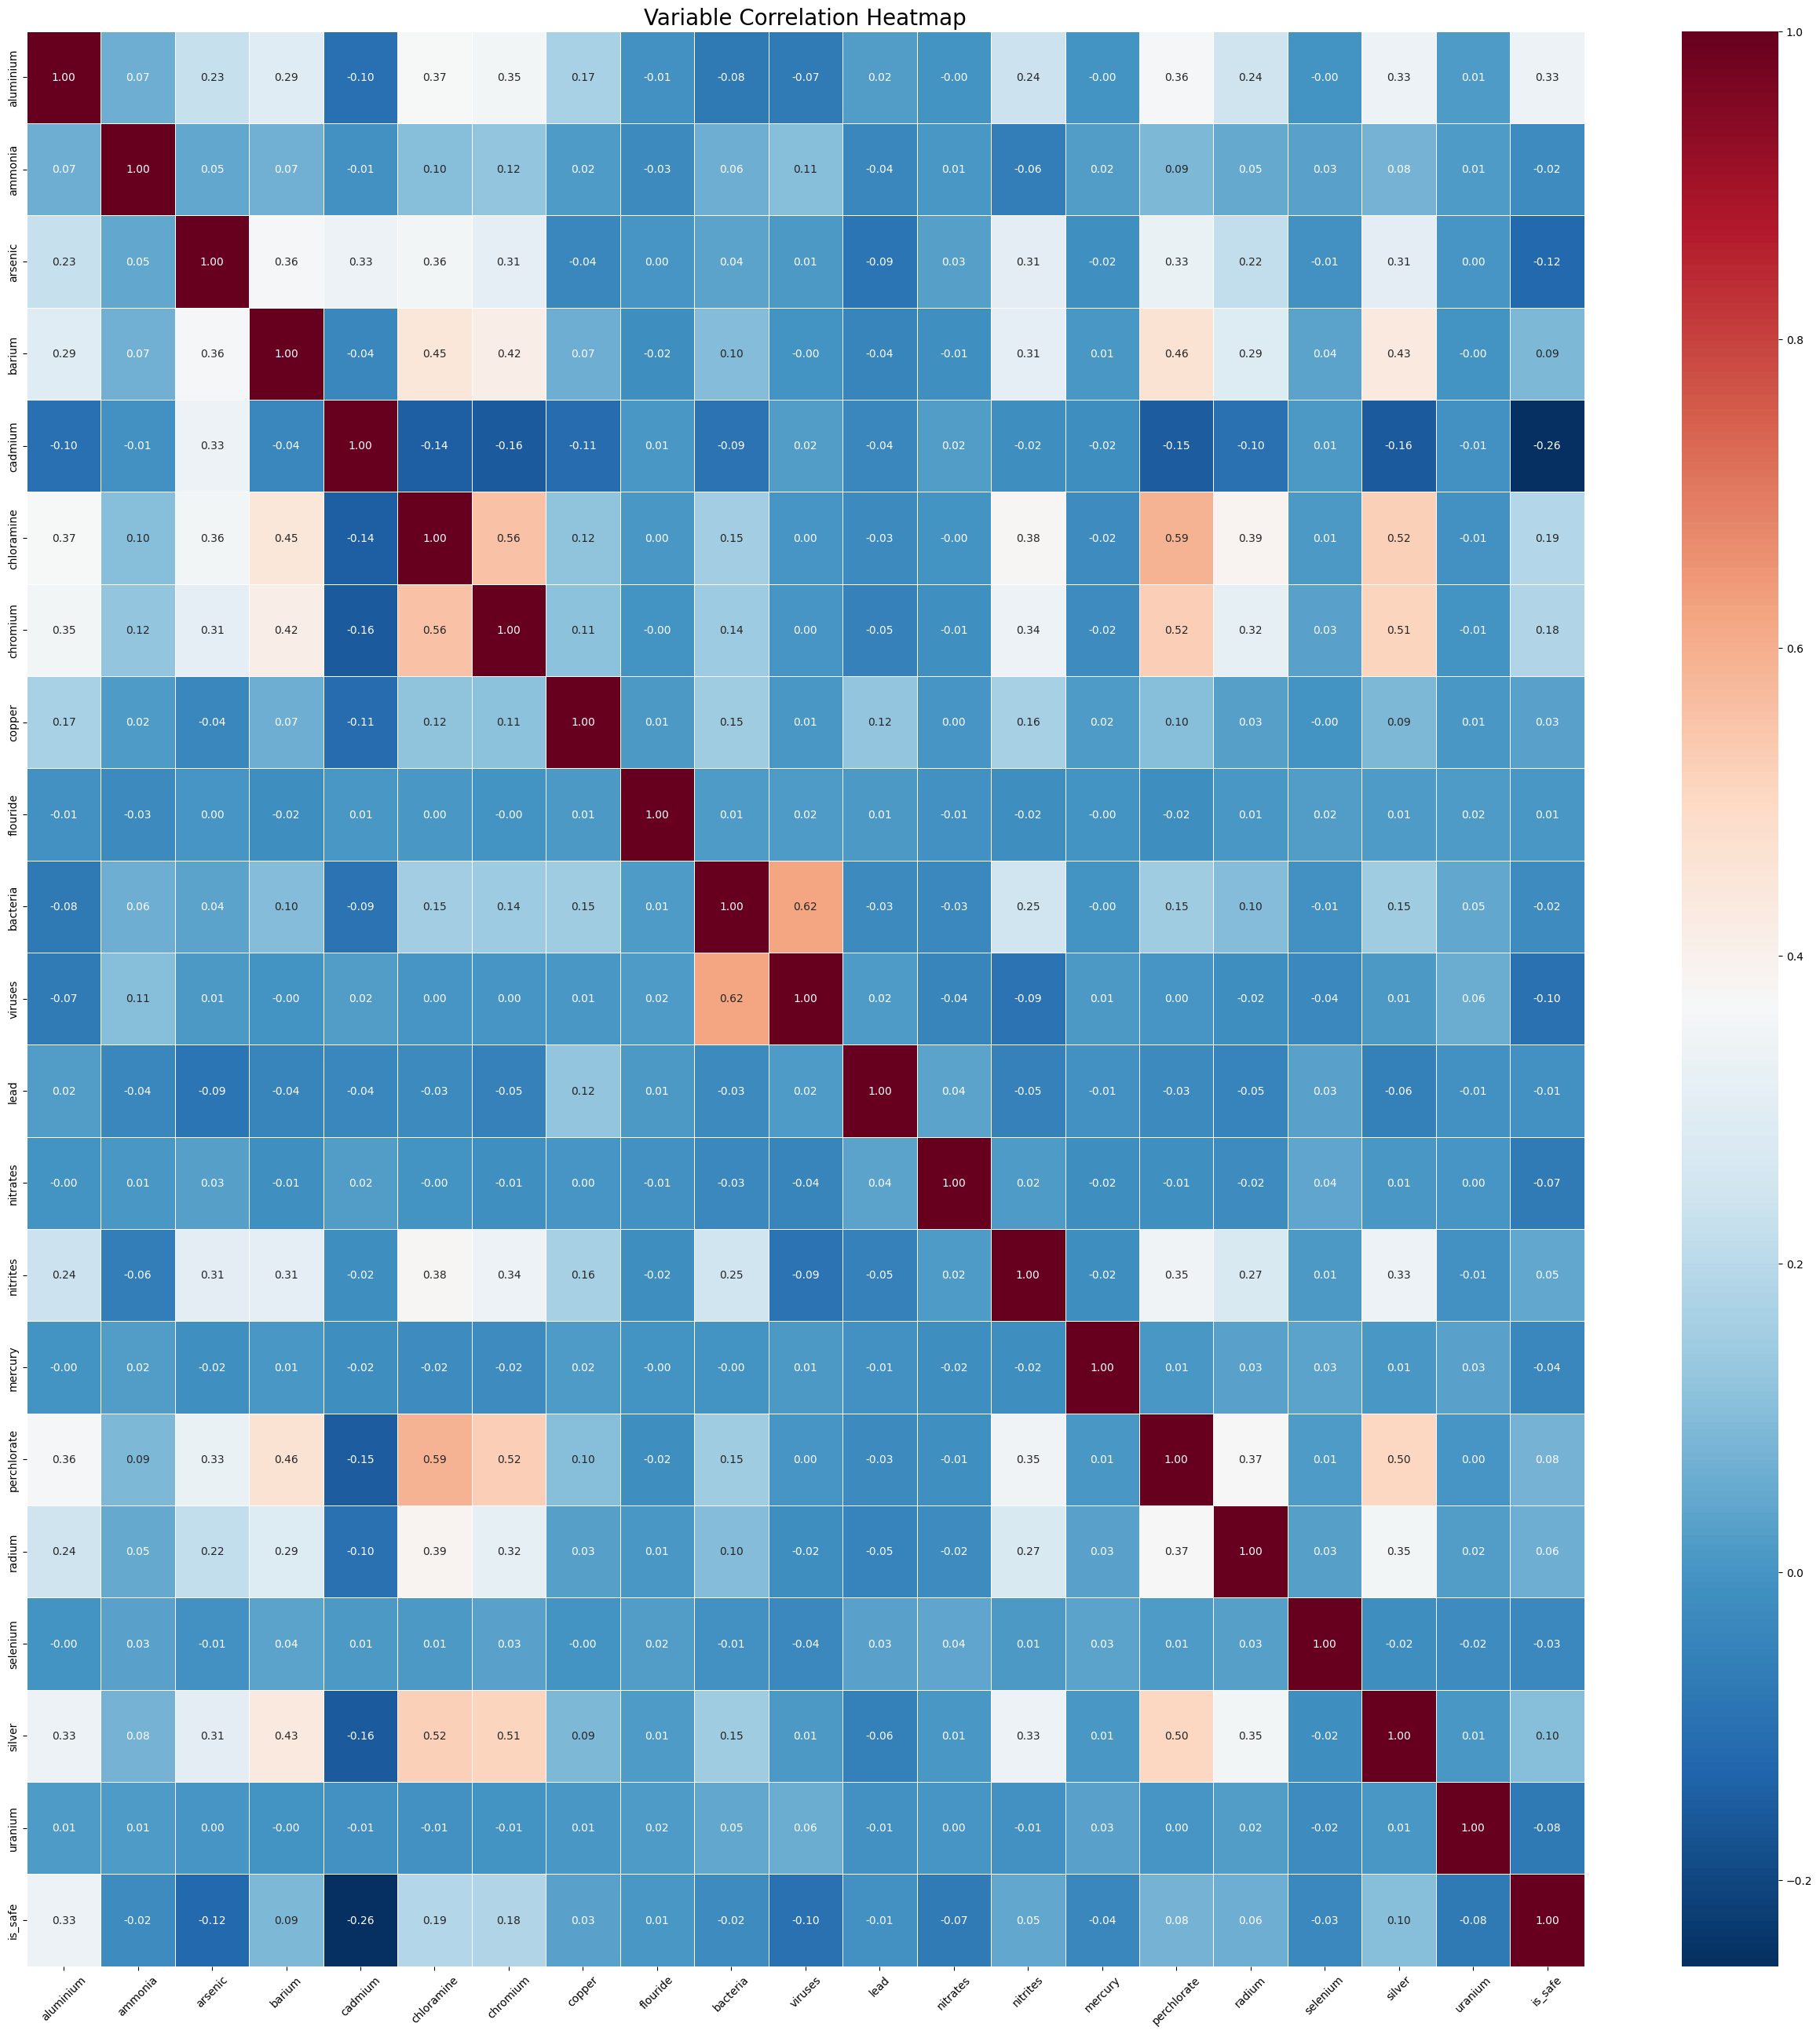

In [11]:
colormap = plt.cm.RdBu_r

correlation_matrix = data.corr()
fig, ax = plt.subplots(figsize=(32, 32))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, fmt=".2f", cmap=colormap, ax=ax)
ax.set_title("Variable Correlation Heatmap", fontsize=20)
plt.xticks(rotation=45)
# plt.savefig('correlations.png')
plt.show()

Observe that the dataset has very high class imbalance. However, because the imbalance favors the class indicating water is not safe to drink, this might be a good thing because I expect the model to be more precise, i.e. have fewer False Positives (saying water is safe even though it's not), and in a real world setting, this would be very important as the cost of a False Positive would be very high. On the other hand, even if False Negatives are high (saying water is not safe when it is), it wouldn't matter that much.

In [12]:
data['is_safe'].value_counts()

is_safe
0    7084
1     912
Name: count, dtype: int64

# Training and tests sets, initial pipeline

Now that the dataset is clean, before applying any other transformation I split the dataset into training and test sets, so that the test set remains untouched. Since we have 8000 observations to work with, I use a 80-20 split.

In [13]:
# I define the target vector and drop it from the dataset

y = data['is_safe']
X = data.drop(['is_safe'], axis=1)

In [14]:
# splitting of the dataset into train and test sets. The stratify command allows me to keep the same distribution between the classes

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=20)

## Preprocessing Pipeline on training dataset

I now define the ColumnTransformer and Pipeline. I only need a MinMaxScaler, as all the features are numerical.

The full Pipeline contains the MinMaxScaler, a feature selector, a sampler for class imbalance and a classifier. The specific pipeline I used is purely for testing purposes, as the model will be cross validated later, where we'll search for the optimal configuration. What matters is having a working skeleton of the pipeline.

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scal', MinMaxScaler(), X_train.columns)
    ],
    verbose_feature_names_out=False,
)

model_pipeline = Pipeline([
    ('trans', preprocessor),
    ('dim_reduction', SelectPercentile(r_regression, percentile=8)),
    ('sample', SMOTE()),
    ('classifier', RandomForestClassifier())
])

In [16]:
# fit the pipeline to the training set

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('scal', MinMaxScaler(),
                                                  Index(['aluminium', 'ammonia', 'arsenic', 'barium', 'cadmium', 'chloramine',
       'chromium', 'copper', 'flouride', 'bacteria', 'viruses', 'lead',
       'nitrates', 'nitrites', 'mercury', 'perchlorate', 'radium', 'selenium',
       'silver', 'uranium'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('dim_reduction',
                 SelectPercentile(percentile=8,
                                  score_func=<function r_regression at 0x7fdc2ad91300>)),
                ('sample', SMOTE()), ('classifier', RandomForestClassifier())])

In [17]:
y_pred = model_pipeline.predict(X_test)

As we can see the F1 score right now is pretty terrible. It's interesting however, that the accuracy is already very high. This can easily be explained by the high imbalance in the classes. If the model predicted everything as just the majority class, the accuracy would be excellent because of the very few observations in the minority where it can go wrong. So in this case, accuracy is not a good metric to assess the model. 

In [18]:
f1_score(y_test, y_pred)

0.39207920792079204

In [19]:
#  accuracy
model_pipeline.score(X_test, y_test)

0.808125

# Cross Validation

I now define the possible configurations for feature selection and classifiers. In previous versions of this model I tried sampling techniques as well, but because they weren't working well anyway, and this model is already slow due to the use of GridSearch and numerous parameter configurations, I omit them in the final version of the model.

## Configurations

In [20]:
# Dimensionality reduction 
dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
]

# Classifiers
classifier_configs = [
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [5, 7]
    },
    {
        'classifier': [AdaBoostClassifier()],
        'classifier__n_estimators' : [10,50,100],
        # 'classifier__estimator': [None, DecisionTreeClassifier()],
        # 'classifier__learning_rate' : [0.01, 1, 10]
        
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__criterion' : ['entropy','gini','log_loss'],
        'classifier__min_samples_leaf': [1,2,3,4,5,10]
    }
]

In [21]:
# I define a dictionary containing all possible combinations of classifiers and parameters to pass to RandomizedSearchCV
all_configs = []
for configuration in itertools.product(dim_reduction_configs,classifier_configs):
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) 

In [22]:
# RandomizedSearchCV samples various configurations and cross validates them to identify the best combination 

rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_parameters),
    n_jobs=-1,
    cv = 2,
    scoring='f1',
    random_state=2
)

In [23]:
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True) #1 minute

In [24]:
rs.fit(X_train, y_train)

for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
RandomForestClassifier(min_samples_leaf=4) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.7857142857142857
----------
None
RandomForestClassifier(min_samples_leaf=4) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.7615894039735099
----------
None
RandomForestClassifier(min_samples_leaf=4) {'bootstra

In [25]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9548472775564408, F1 on test set:0.8120300751879698
F1 on training set:0.9546666666666667, F1 on test set:0.806201550387597
F1 on training set:0.9489051094890512, F1 on test set:0.8113695090439277
F1 on training set:0.951058201058201, F1 on test set:0.795969773299748
F1 on training set:0.9522546419098143, F1 on test set:0.8193384223918575


## Best pipeline

I now define a new pipeline, containing only the optimal configuration, and the pool of parameters to search for the best ones

In [26]:
best_model_pipeline = Pipeline([
    ('trans', preprocessor),
    ('classifier', RandomForestClassifier())
])

## Best parameters search

In [27]:
params = {
    'classifier__criterion' : ['entropy','gini','log_loss'],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5, 10],
    'classifier__n_estimators': [10, 50, 100, 150]
}

In [38]:
# run RandomizedSearch to explore the best parameter combinations

rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2),
    n_iter=20,
    scoring='f1',
    random_state=425
)

In [39]:
rs_best.fit(X_train, y_train) #4 minutes

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(transformers=[('scal',
                                                                               MinMaxScaler(),
                                                                               Index(['aluminium', 'ammonia', 'arsenic', 'barium', 'cadmium', 'chloramine',
       'chromium', 'copper', 'flouride', 'bacteria', 'viruses', 'lead',
       'nitrates', 'nitrites', 'mercury', 'perchlorate', 'radium', 'selenium',
       'silver', 'uranium'],
      dtype='object'))],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=20,
                   param_distributions={'classifier__criterion': ['entropy',
                                                                  'gini',
                                                                  'log_loss'],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         3, 4,
                                                                         5,
                                                                         10],
                                        'classifier__n_estimators': [10, 50,
                                                                     100,
                                                                     150]},
                   random_state=425, scoring='f1')

In [40]:
# best parameters for a RandomForestClassifier() 

rs_best.best_params_ 

{'classifier__n_estimators': 150,
 'classifier__min_samples_leaf': 1,
 'classifier__criterion': 'log_loss'}

In [41]:
# check the F1 score on the test set

f1_score(y_test, rs_best.predict(X_test))

0.8580060422960725

In [42]:
y_pred = rs_best.predict(X_test)

In [43]:
# visualize optimal Pipeline and parameters

rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('scal', MinMaxScaler(),
                                                  Index(['aluminium', 'ammonia', 'arsenic', 'barium', 'cadmium', 'chloramine',
       'chromium', 'copper', 'flouride', 'bacteria', 'viruses', 'lead',
       'nitrates', 'nitrites', 'mercury', 'perchlorate', 'radium', 'selenium',
       'silver', 'uranium'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(criterion='log_loss',
                                        n_estimators=150))])

# Metrics

Now that I have a model, I now graph some metrics to evaluate its performance.

### ROC AUC Curve
I first plot a ROC AUC curve to visualize the ratio of True Positives to False Positives. As mentioned before, because we need the model to minimize False Positive errors as much as possible, this means good precision, and therefore a high AUC score (the are under the ROC curve)

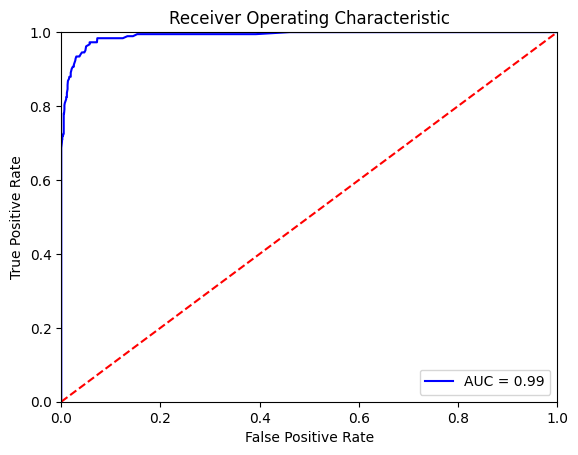

In [44]:
# ROC AUC PLOT

# calculate the FPR and TPR for all thresholds of the classification, using class probabilities
probs = rs_best.best_estimator_.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Confusion Matrix

Next, I plot a confusion matrix to quantify and visualize the performance of the model. My impression is that it did very well as there are few False Positives and False Negatives as well.

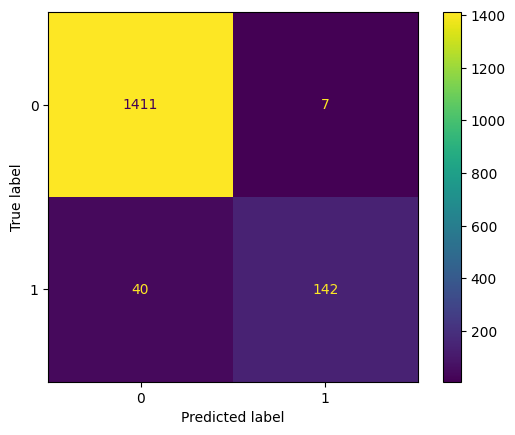

In [45]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

### Learning curves

Next, I visualize the model's learning curves. Unfortunately, the F1 score on the training set and the difference between training and test F1s indicates the model presents high overfitting.

Using RandomForestClassifier, I was hoping it would make it harder to overfit the model, as it is designed to mitigate that. I'm not sure whether the issue lies in parameter choice or model choice entirely. However, I think such a good performance on the test set despite overfitting indicates the model works well enough, and I believe that with a bigger test set we would still get this kind of result.

In [46]:
train_sizes, train_scores, test_scores = learning_curve(rs_best.best_estimator_,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

(0.6, 1.03)

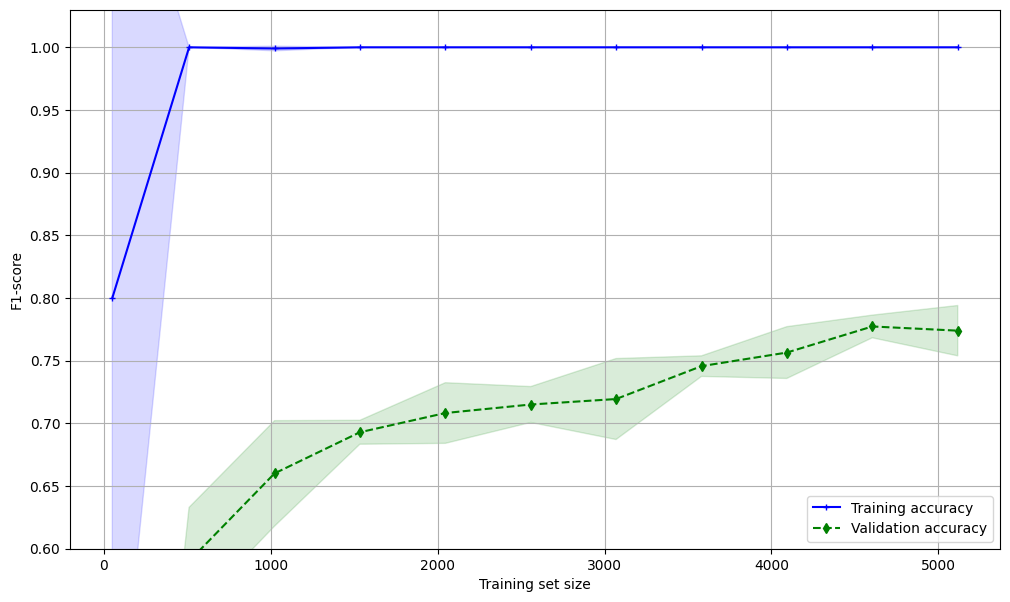

In [47]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=07a611fa-11f4-4f2b-b529-7b8f3376128c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>